In [26]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd

df_train = pd.read_csv('df_train.csv', index_col='row_id')
df_test = pd.read_csv('df_test.csv', index_col='row_id')
target_train = pd.read_csv('target_train.csv', index_col='row_id').squeeze()
target_test = pd.read_csv('target_test.csv', index_col='row_id').squeeze()


In [84]:
def smape_loss(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

def xgb_smape_eval(y_pred, y_true):
    y_true = y_true.get_label()
    return 'SMAPE', smape_loss(y_true, y_pred)

def smape_cv(model, df_train, target_train):
    tscv = TimeSeriesSplit(n_splits=5)
    smape_list = []
    eval_metric_history = []
    for _, (train_index, test_index) in enumerate(tscv.split(df_train), start=1):
        # Create training and validation datasets
        X_train = df_train.iloc[train_index]
        y_train = target_train.iloc[train_index]
        X_valid = df_train.iloc[test_index]
        y_valid = target_train.iloc[test_index]

        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=xgb_smape_eval, verbose=False)
        eval_metric_history.append(model.evals_result())
        # Make predictions
        y_pred = np.exp(model.predict(X_valid)) * X_valid['microbusiness_density']
        y_valid = np.exp(y_valid) * X_valid['microbusiness_density']

        # Calculate SMAPE score
        smape = smape_loss(y_valid, y_pred)
        smape_list.append(smape)

    print(f'Mean SMAPE: {np.mean(smape_list):.4f}')
    return np.mean(smape_list), eval_metric_history

def xgb_objective(trial, df_train, target_train):
    """
    Objective function for XGBoost optimization without rolling window cross-validation.
    """
    params = {
        'n_estimators': 200,
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'random_state': 42,
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'alpha': trial.suggest_float('alpha', 1e-2, 10.0),
        'lambda': trial.suggest_float('lambda', 1e-2, 10.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 250),
    }

    model = xgb.XGBRegressor(**params)
    mean_smape, eval_metric_history = smape_cv(model, df_train, target_train)
    return mean_smape, eval_metric_history

In [54]:
import optuna

# Optimize the XGBoost model
xgb_study = optuna.create_study(direction='minimize')
xgb_study.optimize(lambda trial: xgb_objective(trial, df_train, target_train), n_trials=20)

# Print the best trial for XGBoost
print(f"XGBoost best trial: {xgb_study.best_trial.value} with parameters {xgb_study.best_trial.params}")


[I 2023-04-16 22:36:57,152] A new study created in memory with name: no-name-e8d02c4d-71ec-43d3-9734-f647f49a10d5
[W 2023-04-16 22:38:35,829] Trial 0 failed with parameters: {'colsample_bytree': 0.667765589367521, 'colsample_bynode': 0.8762027934239635, 'max_depth': 7, 'learning_rate': 0.09716330436233225, 'alpha': 0.47600069605321216, 'lambda': 4.12087138176997, 'min_child_weight': 94} because of the following error: The value [{'validation_0': OrderedDict([('mae', [0.45155440808692765, 0.4078368449243854, 0.3683660232942701, 0.33272941947395906, 0.3005545640015969, 0.2715051972651589, 0.2452776929335159, 0.22159880932509357, 0.20022313793542887, 0.18092939543310466, 0.16352609244301147, 0.14784054225814144, 0.13369686292259256, 0.12094719350588594, 0.10945395976782363, 0.09911343069082948, 0.08980755440817907, 0.08143726723627391, 0.0739014662981654, 0.06712793098273236, 0.06105104580864257, 0.05560959805056515, 0.05074084357175618, 0.04638490409558711, 0.04249555471146361, 0.0390538

Mean SMAPE: 1.4005


[W 2023-04-16 22:39:03,911] Trial 1 failed with parameters: {'colsample_bytree': 0.8671232710179341, 'colsample_bynode': 0.3004010767758321, 'max_depth': 7, 'learning_rate': 0.02699841263791619, 'alpha': 8.161491193109288, 'lambda': 9.216266695976865, 'min_child_weight': 156} because of the following error: The value [{'validation_0': OrderedDict([('mae', [0.48653679134493716, 0.4734605753292557, 0.46073721892316394, 0.44835718514396783, 0.43631120563988884, 0.4245902800643876, 0.41318564653638695, 0.40208875180641007, 0.3912913107725734, 0.3807852172978062, 0.37056263328522593, 0.36061589956014206, 0.35093756557264466, 0.34152038932003465, 0.3323573374772439, 0.3234415256899, 0.31476630805374917, 0.30632518768552636, 0.29811184644600214, 0.2901201152731956, 0.2823440634989846, 0.2747778201255282, 0.26741575243376764, 0.2602523470392394, 0.25328223908491726, 0.24650021395500324, 0.23990118990899306, 0.23348023492806044, 0.22723278545252784, 0.22115438833076645, 0.2152400044189984, 0.20

Mean SMAPE: 1.4572


[W 2023-04-16 22:39:21,486] Trial 2 failed with parameters: {'colsample_bytree': 0.342972056845381, 'colsample_bynode': 0.7695002884297353, 'max_depth': 3, 'learning_rate': 0.019455306911009284, 'alpha': 6.124412208025023, 'lambda': 0.7251437035264642, 'min_child_weight': 48} because of the following error: The value [{'validation_0': OrderedDict([('mae', [0.49028452265236006, 0.4807819330179475, 0.47146420716629045, 0.46232776883234117, 0.4533690714937047, 0.4445846581525875, 0.4359711313510567, 0.4275251829622812, 0.41924353482541704, 0.4111229980246275, 0.40316044332288126, 0.3953528011022829, 0.38769706131804216, 0.38019024373451066, 0.37282948731765764, 0.365611931070959, 0.35853477360083047, 0.3515953028021685, 0.34479083656228166, 0.33811875224355553, 0.3315764570285987, 0.32516144753000253, 0.31887125015841844, 0.31270342112511545, 0.3066555762306639, 0.3007253909135232, 0.2949105703573629, 0.2892088794638694, 0.2836181127810586, 0.2781361245979782, 0.2727607691090574, 0.267489

Mean SMAPE: 1.8036


[W 2023-04-16 22:39:40,288] Trial 3 failed with parameters: {'colsample_bytree': 0.9937346634854363, 'colsample_bynode': 0.5190077215628002, 'max_depth': 4, 'learning_rate': 0.01625065151693201, 'alpha': 8.148942078634997, 'lambda': 1.4768522695179618, 'min_child_weight': 139} because of the following error: The value [{'validation_0': OrderedDict([('mae', [0.49188305963593487, 0.4839219652599195, 0.47609024286341745, 0.468385776280368, 0.46080650924940714, 0.4533503854392725, 0.4460154378617371, 0.43879966974756235, 0.43170114399438103, 0.42471798302945757, 0.4178482794845536, 0.411090215470001, 0.4044419431889618, 0.39790170429503846, 0.39146774052110855, 0.3851383232958195, 0.37891175388764764, 0.3727863633708014, 0.3667605125808953, 0.36083256245412965, 0.3550009632160377, 0.34926410556422594, 0.34362046957343323, 0.3380685353286274, 0.33260681270942705, 0.32723384142334566, 0.3219481909111731, 0.3167484307347429, 0.31163316012267617, 0.3066010081732575, 0.30165060399926286, 0.2967

Mean SMAPE: 2.4354


[W 2023-04-16 22:40:06,015] Trial 4 failed with parameters: {'colsample_bytree': 0.5808624892050698, 'colsample_bynode': 0.8749976234906793, 'max_depth': 4, 'learning_rate': 0.019874439329611106, 'alpha': 4.755702043548374, 'lambda': 5.024816382123412, 'min_child_weight': 174} because of the following error: The value [{'validation_0': OrderedDict([('mae', [0.490076621646269, 0.48037426709262726, 0.47086470364913957, 0.46154408695175286, 0.4524086320518213, 0.44345470310607743, 0.4346786642286326, 0.4260769987360685, 0.4176462495581358, 0.40938298941241624, 0.40128391026328775, 0.3933457636703964, 0.3855653309709904, 0.37793948292207147, 0.37046514989040064, 0.36313932180220543, 0.3559590482761573, 0.34892143844095413, 0.34202366113819566, 0.33526294470075463, 0.32863654731156167, 0.3221418166218889, 0.31577612995320564, 0.3095369243663083, 0.30342166662202547, 0.29742791293674065, 0.29155324935473237, 0.2857953214584352, 0.2801517748763145, 0.27462037442310966, 0.269198855150449, 0.26

Mean SMAPE: 1.7522


[W 2023-04-16 22:40:25,827] Trial 5 failed with parameters: {'colsample_bytree': 0.18780238292214207, 'colsample_bynode': 0.28221674235862376, 'max_depth': 10, 'learning_rate': 0.026858747192425068, 'alpha': 7.112702897363626, 'lambda': 1.9850257781567158, 'min_child_weight': 112} because of the following error: The value [{'validation_0': OrderedDict([('mae', [0.48659916747612675, 0.47358193038942803, 0.46091427444545624, 0.44858684182153413, 0.43659045337679375, 0.42491622807627566, 0.41355552316124544, 0.4024999344432786, 0.39174123646775727, 0.3812714719898838, 0.3710828924288528, 0.36116792797090996, 0.3515192472771399, 0.3421296679989287, 0.33299227595741854, 0.32410027622225274, 0.31544705271962975, 0.30702622770908516, 0.29883154271740875, 0.29085694789190897, 0.2830965125337767, 0.2755444848399694, 0.26819526197473054, 0.2610434198650927, 0.2540836532944762, 0.2473107923548286, 0.2407198150782173, 0.23430584870650917, 0.22806426449160194, 0.22199087363661552, 0.216080587054886

Mean SMAPE: 1.4628


[W 2023-04-16 22:40:48,512] Trial 6 failed with parameters: {'colsample_bytree': 0.991609707117814, 'colsample_bynode': 0.9816596567979452, 'max_depth': 8, 'learning_rate': 0.012315915772321996, 'alpha': 7.580792815495513, 'lambda': 9.49523661569629, 'min_child_weight': 101} because of the following error: The value [{'validation_0': OrderedDict([('mae', [0.4938449168152752, 0.48778965105134015, 0.4818089210303791, 0.47590180275850197, 0.4700674021200064, 0.46430482505118775, 0.4586131775428962, 0.4529915952936857, 0.44743918420916445, 0.4419551396487909, 0.4365385973290198, 0.4311887228368219, 0.4259047115069356, 0.42068572881210725, 0.4155309999217895, 0.41043972017242547, 0.40541111471130487, 0.4004444086575875, 0.39553882718839783, 0.390693625231185, 0.38590805767759645, 0.3811814093477604, 0.3765129351537824, 0.371901919835663, 0.36734767795447854, 0.3628494942101657, 0.35840668318852104, 0.3540185594608497, 0.349684437519182, 0.34540366173458825, 0.34117557644404206, 0.3369995558

Mean SMAPE: 4.4497


[W 2023-04-16 22:41:05,915] Trial 7 failed with parameters: {'colsample_bytree': 0.34673618017537533, 'colsample_bynode': 0.10019127103159692, 'max_depth': 9, 'learning_rate': 0.029469715050784, 'alpha': 5.5682091391729, 'lambda': 3.127725880890153, 'min_child_weight': 129} because of the following error: The value [{'validation_0': OrderedDict([('mae', [0.4852971935645918, 0.47105123639689805, 0.45722501516328523, 0.44380619168779367, 0.4307827556319439, 0.4181430244700163, 0.40587573289687096, 0.39396988393141213, 0.38241483807209176, 0.3712002539573671, 0.36031608819692185, 0.34975262523280504, 0.339500417716886, 0.3295502865236402, 0.31989332080470445, 0.3105209076275345, 0.30142464277728065, 0.29259639024720857, 0.28402825234602014, 0.2757125699356787, 0.26764189245519304, 0.2598090370240388, 0.25220697129487407, 0.24482888470011577, 0.23766819134761197, 0.2307184835300587, 0.2239741551418148, 0.21742870477582, 0.2110762541963316, 0.20491153478586635, 0.19892846374014314, 0.193121

Mean SMAPE: 1.4387


[W 2023-04-16 22:42:14,555] Trial 8 failed with parameters: {'colsample_bytree': 0.49179210642066196, 'colsample_bynode': 0.593994415274133, 'max_depth': 10, 'learning_rate': 0.05708321835993042, 'alpha': 5.521618903097768, 'lambda': 7.41696760617279, 'min_child_weight': 40} because of the following error: The value [{'validation_0': OrderedDict([('mae', [0.471550097500328, 0.44474651456717995, 0.41947229745121256, 0.3956402146993898, 0.373167952305801, 0.35197793484231943, 0.3319969975998115, 0.3131561481857537, 0.2953903579693502, 0.2786382638997586, 0.2628420197902681, 0.24794710167960643, 0.23390207184403733, 0.22065942839242372, 0.20817336769248507, 0.19640064303603968, 0.18530122013836647, 0.17484225315304971, 0.16498390095894783, 0.1556990396063699, 0.14695216398235453, 0.1387094527186344, 0.13094455997916327, 0.1236288205254157, 0.11673532208478613, 0.11024269130913966, 0.10413497368752953, 0.09838545634190977, 0.09297308867310204, 0.08787820083954113, 0.08308137826462555, 0.07

Mean SMAPE: 1.4044


[W 2023-04-16 22:44:13,150] Trial 9 failed with parameters: {'colsample_bytree': 0.8947156822615059, 'colsample_bynode': 0.8069205601077828, 'max_depth': 9, 'learning_rate': 0.06362730287932007, 'alpha': 1.1102198737645852, 'lambda': 7.931892378128881, 'min_child_weight': 181} because of the following error: The value [{'validation_0': OrderedDict([('mae', [0.46827625278480456, 0.4385929012484753, 0.4107973778365808, 0.3847696089615341, 0.3603971505138164, 0.33757474064387116, 0.3162037932896981, 0.29619201062988015, 0.27745296594909874, 0.25990568598793407, 0.24347438414252245, 0.2280882228174176, 0.21368211726911907, 0.20019361057999777, 0.18756387366975966, 0.17574513986588247, 0.1646834532280896, 0.15433888212481406, 0.14466117555709762, 0.13560573214725896, 0.12713619965034248, 0.11921119729301918, 0.11179776669893704, 0.10487219798489728, 0.09840049369772227, 0.09235161138120625, 0.086698265921941, 0.08141339369858541, 0.07648013110341473, 0.07187169852984776, 0.06757082532790615

Mean SMAPE: 1.3881


[W 2023-04-16 22:44:43,151] Trial 10 failed with parameters: {'colsample_bytree': 0.9049941285187121, 'colsample_bynode': 0.39621149238799613, 'max_depth': 9, 'learning_rate': 0.024180975490449716, 'alpha': 9.069133953214877, 'lambda': 5.526830011497381, 'min_child_weight': 220} because of the following error: The value [{'validation_0': OrderedDict([('mae', [0.48793791774160616, 0.4761911832901332, 0.46472843528035973, 0.45354275942176087, 0.44262748004356217, 0.43197607042522684, 0.4215821230461311, 0.4114394390718062, 0.40154193879524064, 0.39188369156877045, 0.3824589157222467, 0.37326197861929544, 0.36428736687630564, 0.3555296861970597, 0.3469837212595294, 0.3386443460011849, 0.33050655365488046, 0.32256548643609995, 0.3148163759553605, 0.3072545730912858, 0.29987557767444206, 0.29267494916987497, 0.2856483960116212, 0.27879168626478706, 0.2721007371075291, 0.2655715251257392, 0.2592001458085802, 0.25298278535212293, 0.2469157179294704, 0.24099530775148367, 0.23521800834520834, 0

Mean SMAPE: 1.5140


[W 2023-04-16 22:45:07,748] Trial 11 failed with parameters: {'colsample_bytree': 0.7104922600171187, 'colsample_bynode': 0.219247238104316, 'max_depth': 5, 'learning_rate': 0.038234589379568765, 'alpha': 7.510882636173881, 'lambda': 3.8972310715754794, 'min_child_weight': 192} because of the following error: The value [{'validation_0': OrderedDict([('mae', [0.4809366070881881, 0.4626253748663257, 0.44501410963694743, 0.4280760490944099, 0.4117854738404594, 0.39611761807017876, 0.3810486698277134, 0.36655574083058884, 0.3526168370245523, 0.3392107689336661, 0.32631715178987497, 0.31391640544009286, 0.3019896948088989, 0.2905189001371315, 0.27948658703721146, 0.26887597678202896, 0.25867097577396914, 0.24885607252180778, 0.2394163657317997, 0.23033749064321166, 0.22160654210884398, 0.21320946181778927, 0.20513419662088397, 0.19736771570668532, 0.18989853693902115, 0.18271720398780678, 0.17581381513968627, 0.16917548541146485, 0.16279425162208905, 0.15666238166974478, 0.15076928595229613

Mean SMAPE: 1.4106


[W 2023-04-16 22:45:45,791] Trial 12 failed with parameters: {'colsample_bytree': 0.5160200272949182, 'colsample_bynode': 0.7086172063079772, 'max_depth': 9, 'learning_rate': 0.0171570361024373, 'alpha': 0.1859962502201014, 'lambda': 7.459516890272866, 'min_child_weight': 62} because of the following error: The value [{'validation_0': OrderedDict([('mae', [0.49142678607506474, 0.48302455773841024, 0.47476642369954636, 0.4666499101884114, 0.458672603377147, 0.4508320891923977, 0.44312604309649073, 0.4355521404656589, 0.4281081461973263, 0.42079182507980745, 0.413600971699477, 0.40653344037777484, 0.3995871150705363, 0.39275990964076685, 0.38604979752287233, 0.37945475219473207, 0.3729728066996588, 0.36660202384748597, 0.3603404962853186, 0.35418634653248277, 0.34813775657059487, 0.34219287873153237, 0.3363499546109331, 0.33060725570393334, 0.32496302366754526, 0.319415589563191, 0.3139633142784827, 0.30860452891064416, 0.30333765386669037, 0.29816110967467996, 0.29307331678680626, 0.288

Mean SMAPE: 2.1804


[W 2023-04-16 22:46:17,858] Trial 13 failed with parameters: {'colsample_bytree': 0.48233623360018163, 'colsample_bynode': 0.7124175323106422, 'max_depth': 5, 'learning_rate': 0.019557750439849052, 'alpha': 0.5649880749477181, 'lambda': 6.555073767433794, 'min_child_weight': 23} because of the following error: The value [{'validation_0': OrderedDict([('mae', [0.49023052084419355, 0.4806759262458662, 0.4713081324073558, 0.46212347388935815, 0.45311837435948427, 0.44428931715818354, 0.43563287497064584, 0.4271456802145689, 0.4188243949633565, 0.41066580057641977, 0.4026667082342456, 0.3948240184910435, 0.3871346616820349, 0.37959562779823136, 0.372203966366243, 0.3649568164406908, 0.357851376537634, 0.3508848452592263, 0.3440545105966876, 0.33735772013906334, 0.33079185126834465, 0.3243543410359514, 0.31804268599139573, 0.3118544125640824, 0.3057871365571389, 0.29983847379841294, 0.2940060996956768, 0.2882877790738991, 0.2826812469770363, 0.2771843278133912, 0.27179487583961975, 0.266510

Mean SMAPE: 1.7727


[W 2023-04-16 22:46:30,381] Trial 14 failed with parameters: {'colsample_bytree': 0.1587023632609441, 'colsample_bynode': 0.1800249867012401, 'max_depth': 5, 'learning_rate': 0.027327688192706277, 'alpha': 9.173251489311237, 'lambda': 4.447990996299567, 'min_child_weight': 242} because of the following error: The value [{'validation_0': OrderedDict([('mae', [0.4863707624807571, 0.4731375777711517, 0.4602659249491894, 0.44774593949645264, 0.4355680251171302, 0.42372282388028765, 0.4122012162249814, 0.40099441052748147, 0.3900937640878703, 0.37949093223456887, 0.3691777789685145, 0.359146406648702, 0.34938909649068123, 0.339898368115795, 0.33066691993289543, 0.3216876888333452, 0.3129537606314673, 0.3044584596061944, 0.2961952590949543, 0.2881578111544905, 0.28033994673646073, 0.2727356755570166, 0.26533915637716615, 0.258144726350756, 0.2511468430726699, 0.24434015645363888, 0.23771943646823507, 0.23127958669770085, 0.2250161784651023, 0.218924103592116, 0.2129984706104071, 0.2072353158

Mean SMAPE: 1.4640


[W 2023-04-16 22:47:51,911] Trial 15 failed with parameters: {'colsample_bytree': 0.8272209337238366, 'colsample_bynode': 0.7247130498421002, 'max_depth': 7, 'learning_rate': 0.07468966125552003, 'alpha': 1.262518721672454, 'lambda': 3.5889282930225344, 'min_child_weight': 246} because of the following error: The value [{'validation_0': OrderedDict([('mae', [0.46275635599820664, 0.4283164048261715, 0.3964482152631126, 0.36695977092542786, 0.33967336058858727, 0.31442453502742645, 0.29106115340490946, 0.26944242954325753, 0.24943806728963264, 0.2309275170158763, 0.2138010000697188, 0.19795520853501192, 0.18329561401198421, 0.16974092394115245, 0.15721082955847737, 0.14563264622009972, 0.13492846287994525, 0.12503632181994015, 0.1158913075103465, 0.1074447349243654, 0.09965068400677599, 0.09245418672448341, 0.08581014639304203, 0.07967622167746267, 0.07401971884639112, 0.06880372928134855, 0.06399699332216302, 0.05957026549849755, 0.05549849123203807, 0.05176310279325574, 0.0483293702598

Mean SMAPE: 1.3879


[W 2023-04-16 22:48:35,306] Trial 16 failed with parameters: {'colsample_bytree': 0.7888034534896438, 'colsample_bynode': 0.7959392560393546, 'max_depth': 4, 'learning_rate': 0.041290676373262176, 'alpha': 4.823518452854562, 'lambda': 7.63198416139364, 'min_child_weight': 31} because of the following error: The value [{'validation_0': OrderedDict([('mae', [0.4794128739679032, 0.4596987867950677, 0.4407983625087222, 0.42267798425969744, 0.4053054952807629, 0.38865002038041596, 0.37268196583888696, 0.3573729598631637, 0.34269579291500535, 0.3286243879640275, 0.31513374090863, 0.30219989061512437, 0.2897998595193747, 0.27791159390451897, 0.2665139937680753, 0.2555867930406782, 0.24511060610436566, 0.23506679135970834, 0.2254379522763962, 0.2162071579289337, 0.2073579095037631, 0.19887432529324695, 0.19074120634354727, 0.18294611453326368, 0.17547670490074388, 0.16831710113161427, 0.1614573027246652, 0.15488727833087096, 0.14859196145485348, 0.14255941562973848, 0.13677810249157243, 0.1312

Mean SMAPE: 1.4043


[W 2023-04-16 22:48:56,142] Trial 17 failed with parameters: {'colsample_bytree': 0.15813674457145277, 'colsample_bynode': 0.7323371577710655, 'max_depth': 3, 'learning_rate': 0.09883355944671417, 'alpha': 4.18194365055342, 'lambda': 1.0930071372419314, 'min_child_weight': 136} because of the following error: The value [{'validation_0': OrderedDict([('mae', [0.4507344567842556, 0.406359663027408, 0.36637031079262644, 0.330333014719683, 0.2978571855807412, 0.26859085799358057, 0.24221683036491012, 0.218450524420523, 0.19703606193822662, 0.1777460111191, 0.16037961936995704, 0.14475824256543676, 0.13069925277889896, 0.1180484640718318, 0.10667158805456582, 0.09645469084711944, 0.08727516283084398, 0.0790284401847169, 0.07162876037915834, 0.06499433703816467, 0.05905233398629683, 0.0537416468900854, 0.04900584142514698, 0.04477756692539956, 0.04101868897774923, 0.0376832931799076, 0.0347322463367204, 0.03212501443647614, 0.02983430252398698, 0.02782966512816956, 0.02607687414446866, 0.024

Mean SMAPE: 1.4006


[W 2023-04-16 22:49:26,478] Trial 18 failed with parameters: {'colsample_bytree': 0.910285430017683, 'colsample_bynode': 0.9464098953205959, 'max_depth': 7, 'learning_rate': 0.016051213665960015, 'alpha': 9.986921288321968, 'lambda': 2.755791439161582, 'min_child_weight': 15} because of the following error: The value [{'validation_0': OrderedDict([('mae', [0.49198465585183526, 0.4841219091772058, 0.4763853454903875, 0.4687729382522114, 0.4612826907701565, 0.45391266584723694, 0.44666092635551286, 0.4395255649224837, 0.43250470400098656, 0.42559652567748574, 0.4187992119873002, 0.41211097479279146, 0.40553008558227654, 0.3990548157562729, 0.3926834666906618, 0.3864143693616233, 0.3802458846678512, 0.3741764032702978, 0.3682043159100428, 0.3623280727776706, 0.3565461242291346, 0.35085698009290833, 0.3452591502682158, 0.3397511446363804, 0.3343315327123526, 0.3289989137716366, 0.3237518572848569, 0.31858902216540697, 0.31350903750219483, 0.3085105919913306, 0.3035923444976196, 0.298753043

Mean SMAPE: 2.5064


[W 2023-04-16 22:49:55,143] Trial 19 failed with parameters: {'colsample_bytree': 0.35643438978354036, 'colsample_bynode': 0.4153175288559019, 'max_depth': 8, 'learning_rate': 0.09990054765424579, 'alpha': 8.954457326938517, 'lambda': 8.582635903847724, 'min_child_weight': 57} because of the following error: The value [{'validation_0': OrderedDict([('mae', [0.4502514207447007, 0.4054922664419859, 0.3652023577680236, 0.32893546462556833, 0.29628988145660135, 0.26690401671683717, 0.24045236903455286, 0.2166433991634916, 0.19521490120449952, 0.17593561186742934, 0.15860001629467899, 0.14302402565764125, 0.12902232110423617, 0.11643685322468214, 0.10513550446663211, 0.09499724846642055, 0.08589900800187154, 0.0777363202799772, 0.07042077217607161, 0.06387105336431222, 0.05801347087657218, 0.05278713642203196, 0.04813176771877021, 0.04398237295479893, 0.04030312319031454, 0.03703935635062768, 0.0341548698993016, 0.0316112991808135, 0.02938091126152053, 0.02743244758055341, 0.025731415869710

Mean SMAPE: 1.4067


ValueError: No trials are completed yet.

In [55]:
train_df = pd.read_csv('train.csv')
params = xgb_study.best_params
xgb_model = xgb.XGBRegressor(**params)

ValueError: No trials are completed yet.

In [85]:
mean_smape, eval_metric_history = smape_cv(xgb_model, df_train, target_train)

# import matplotlib.pyplot as plt

# def plot_losses(eval_metric_history):
#     n_splits = len(eval_metric_history)
#     plt.figure(figsize=(12, 6))
    
#     for i, history in enumerate(eval_metric_history, start=1):
#         train_loss = history['validation_0']['SMAPE']
#         val_loss = history['validation_1']['SMAPE']
#         epochs = len(train_loss)
        
#         plt.subplot(n_splits, 1, i)
#         plt.plot(range(epochs), train_loss, label="Train Loss")
#         plt.plot(range(epochs), val_loss, label="Validation Loss")
#         plt.xlabel("Epochs")
#         plt.ylabel("SMAPE")
#         plt.title(f"Fold {i}")
#         plt.legend()

#     plt.tight_layout()
#     plt.show()

# plot_losses(eval_metric_history)


/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Mean SMAPE: 1.4928


In [83]:
import matplotlib.pyplot as plt
def plot_rmse(eval_metric_history):
    n_splits = len(eval_metric_history)
    plt.figure(figsize=(12, 6))

    for i, history in enumerate(eval_metric_history, start=1):
        train_rmse = history['validation_0']['rmse']
        val_rmse = history['validation_1']['rmse']
        epochs = len(train_rmse)

        plt.subplot(n_splits, 1, i)
        plt.plot(range(epochs), train_rmse, label="Train RMSE")
        plt.plot(range(epochs), val_rmse, label="Validation RMSE")
        plt.xlabel("Epochs")
        plt.ylabel("RMSE")
        plt.title(f"Fold {i}")
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_rmse(eval_metric_history)


KeyError: 'validation_1'

<Figure size 1200x600 with 0 Axes>

In [43]:
xgb_model.fit(df_train, target_train)
y_pred = np.exp(xgb_model.predict(df_test)) * df_test.microbusiness_density

In [44]:
my_cfips = df_train['cfips'].unique()
train = train_df[train_df.cfips.isin(my_cfips)]
pred = y_pred.values
y_true = train[train.row_id.str.contains('2022-07-01')].microbusiness_density.values
print(smape_loss(y_true, pred))

1.952320141996125


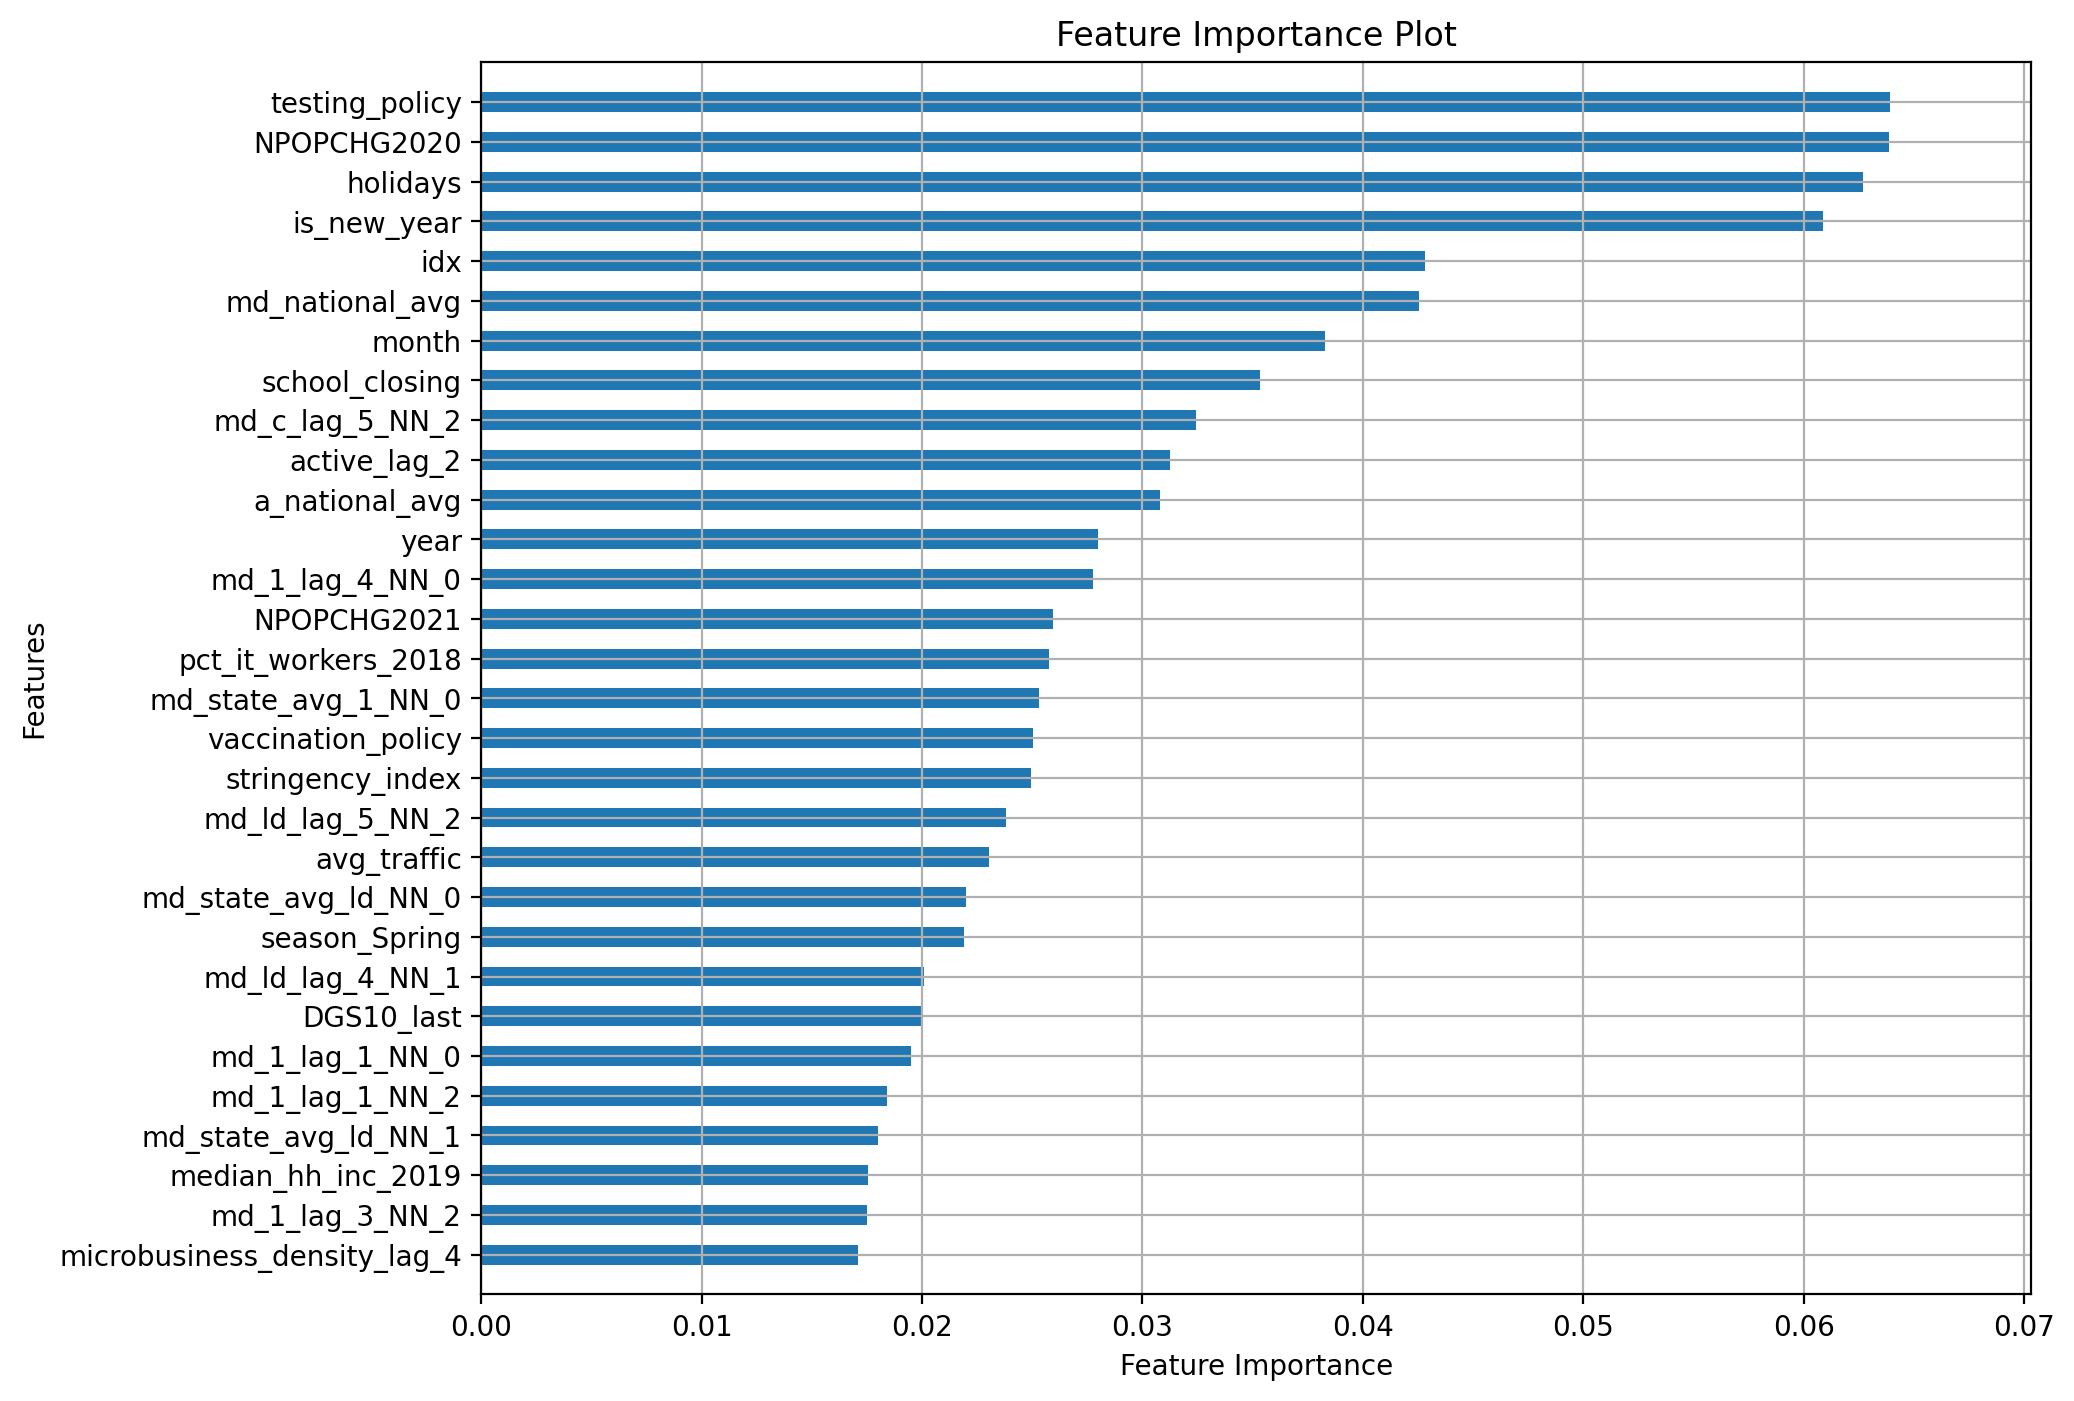

In [87]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8), dpi=200)
plot_importance(xgb_model, ax=ax, max_num_features=30, importance_type='gain', show_values=False, height=0.5, xlabel='Feature Importance', ylabel='Features', title='Feature Importance Plot')
plt.show()


In [89]:
df_train.testing_policy

array([1.        , 1.5       , 2.        , 2.86666667, 3.        ,
       2.41935484, 1.53571429, 1.51724138, 1.78947368, 1.68181818,
       1.73333333, 1.91666667, 1.78571429, 1.75862069, 2.67741935,
       1.33333333, 2.5483871 , 2.06666667, 2.87096774, 1.4       ,
       1.37037037, 1.55555556, 1.35714286, 1.43478261, 1.47619048,
       1.34482759, 1.38461538, 2.3       , 1.4137931 , 1.48      ,
       1.42857143, 1.4516129 , 2.16129032, 1.63636364, 1.56      ,
       1.53846154, 1.46666667, 2.61290323, 1.77419355, 2.51612903,
       1.58064516, 2.2       , 1.16666667, 2.80645161, 1.2       ,
       0.61904762, 0.59090909, 0.54166667, 0.76470588, 0.52      ,
       0.92857143, 0.72222222, 1.19230769, 0.56521739, 1.17857143,
       1.26315789, 0.8125    , 0.43333333, 0.68421053, 1.20833333,
       1.25      , 0.5       , 0.86666667, 2.86206897, 1.17241379,
       1.18518519, 1.09677419, 2.46666667, 0.84615385, 1.38709677,
       1.96774194, 2.77419355, 2.82758621, 1.1       , 2.53333